*Please do not share any image from this jupyter notebook, it is confidential.*

In [42]:
import pandas as pd 
import tensorflow as tf
import numpy as np
import scipy.misc


#from PIL import Image
import PIL.Image as Image
import torchvision.transforms as transforms

to_tensor = transforms.ToTensor()
import torchvision
import torch.nn as nn

import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from functools import partial
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!pip install torchinfo
from torchinfo import summary

from keras.layers import Dense, GlobalAveragePooling2D
#from  import keras.layers.Add


import tensorflow

import os

import keras

from tensorflow.keras import layers

from zipfile import ZipFile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

import matplotlib.pyplot as plt


Defaulting to user installation because normal site-packages is not writeable


### Metadata have the patient IDs, tumor location of the corresponding images, and response to therapy.

In [ ]:
metadata = pd.read_excel('/oak/stanford/groups/ccurtis2/users/bgsimon/CS230_CourseProject/simplified_metadata.xlsx')

metadata['y'] = np.where(metadata['iRECIST_response']== 'responders', 1, 0)

aFileNames = metadata.loc[metadata['Localization'] == 'Lymphnode']['fov'].values.tolist()

aFileNamesLabels = metadata.loc[metadata['Localization'] == 'Lymphnode']['y'].values.tolist()

aFileNames_train, aFileNames_test, aFileNamesLabels_train, aFileNamesLabels_test = train_test_split(aFileNames, aFileNamesLabels, test_size=0.2, random_state=42)


In [ ]:
biomarker_toKeep = ['Calprotectin',
 'CD11c',
 'CD14',
 'CD163',
 'CD20',
 'CD3',
 'CD31',
 'CD4',
 'CD45',
 'CD56',
 'CD68',
 'CD8',
 'ChyTr',
 'CK17',
 'FAP',
 'FOXP3',
 'HLADR',
 'PD1',
 'PDL1',
 'SMA']


markerNum = len(biomarker_toKeep)
markerNum

In [ ]:
from torchvision import datasets


RAW_Image_Source_Folder = '/oak/stanford/groups/ccurtis2/users/bgsimon/CS230_CourseProject/pred_progress_v_0_images/'

def my_tiff_loader(filename):    

    
    head_tail = os.path.split(filename)
    filenameWithTiff = head_tail[-1]
    
    
    fileNameToBeUsed = filenameWithTiff[0:-(len('.tiff'))] 
    
        
    folder_path = RAW_Image_Source_Folder+fileNameToBeUsed+'/'
    
    cdir = !ls $folder_path
   
    for n in cdir:
        if n[-5:] == '.tiff':
            newn = n.replace(".tiff", ".tif" )
            os.rename(folder_path+n, folder_path+newn)

    i=0
    cdir = !ls $folder_path
    for my_tif in cdir:
       
        biomarkerName = my_tif[0:-(len('.tif'))]
     
        if biomarkerName in biomarker_toKeep:
        
            image_dir = folder_path+my_tif
            if i==0:
                im = Image.open(image_dir)
                im = im.resize([224,224])
                image = to_tensor(im)
            else:
                im = Image.open(image_dir) 
                im = im.resize([224,224])
                next_channel = to_tensor(im)
                image = torch.cat((image,next_channel),0)
            i += 1



    return image
    

In [49]:
train_data = np.zeros((66,20,224,224))
for sample in range(len(aFileNames_train)):
    print(aFileNames_train[sample])
    train_data[sample,:,:,:] = my_tiff_loader(aFileNames_train[sample] + ".tiff")

TONIC_TMA13_R2C6
TONIC_TMA11_R9C5
TONIC_TMA7_R10C6
TONIC_TMA3_R4C6
TONIC_TMA12_R8C2
TONIC_TMA3_R3C2
TONIC_TMA9_R8C5
TONIC_TMA14_R9C6
TONIC_TMA19_R9C4
TONIC_TMA8_R1C2
TONIC_TMA18_R1C6
TONIC_TMA5_R11C1
TONIC_TMA7_R5C2
TONIC_TMA12_R7C6
TONIC_TMA22_R12C3
TONIC_TMA3_R5C1
TONIC_TMA20_R6C6
TONIC_TMA18_R1C5
TONIC_TMA11_R12C4
TONIC_TMA22_R11C4
TONIC_TMA12_R4C3
TONIC_TMA9_R7C1
TONIC_TMA4_R6C3
TONIC_TMA18_R6C1
TONIC_TMA10_R1C5
TONIC_TMA5_R10C5
TONIC_TMA7_R5C1
TONIC_TMA3_R5C2
TONIC_TMA13_R3C1
TONIC_TMA3_R3C3
TONIC_TMA14_R3C1
TONIC_TMA19_R10C3
TONIC_TMA13_R3C2
TONIC_TMA17_R7C6
TONIC_TMA9_R8C4
TONIC_TMA20_R6C5
TONIC_TMA11_R5C6
TONIC_TMA13_R10C3
TONIC_TMA8_R1C1
TONIC_TMA13_R10C2
TONIC_TMA17_R7C4
TONIC_TMA5_R1C3
TONIC_TMA9_R2C5
TONIC_TMA20_R7C1
TONIC_TMA22_R12C4
TONIC_TMA11_R9C6
TONIC_TMA4_R4C3
TONIC_TMA14_R10C1
TONIC_TMA20_R1C6
TONIC_TMA18_R6C2
TONIC_TMA19_R9C3
TONIC_TMA20_R7C2
TONIC_TMA7_R3C1
TONIC_TMA6_R1C1
TONIC_TMA21_R6C5
TONIC_TMA18_R10C4
TONIC_TMA11_R12C6
TONIC_TMA21_R6C6
TONIC_TMA5_R1C2
TONIC_

In [50]:
train_data1 = np.moveaxis(train_data, [1], [3])

In [51]:
train_labels = np.array(aFileNamesLabels_train)

In [52]:
val_data = np.zeros((17,20,224,224))
for sample in range(len(aFileNames_test)):
    print(aFileNames_train[sample])
    val_data[sample,:,:,:] = my_tiff_loader(aFileNames_test[sample] + ".tiff")

TONIC_TMA13_R2C6
TONIC_TMA11_R9C5
TONIC_TMA7_R10C6
TONIC_TMA3_R4C6
TONIC_TMA12_R8C2
TONIC_TMA3_R3C2
TONIC_TMA9_R8C5
TONIC_TMA14_R9C6
TONIC_TMA19_R9C4
TONIC_TMA8_R1C2
TONIC_TMA18_R1C6
TONIC_TMA5_R11C1
TONIC_TMA7_R5C2
TONIC_TMA12_R7C6
TONIC_TMA22_R12C3
TONIC_TMA3_R5C1
TONIC_TMA20_R6C6


In [64]:
val_data.shape

(17, 20, 224, 224)

In [53]:
val_data1 = np.moveaxis(val_data, [1], [3])

In [54]:
val_labels = np.array(aFileNamesLabels_test)

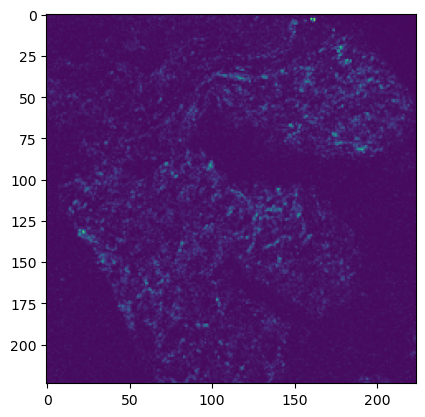

In [66]:
plt.imshow(train_data1[1,:,:,1])

In [71]:
np.max(train_data1)

0.8246471285820007

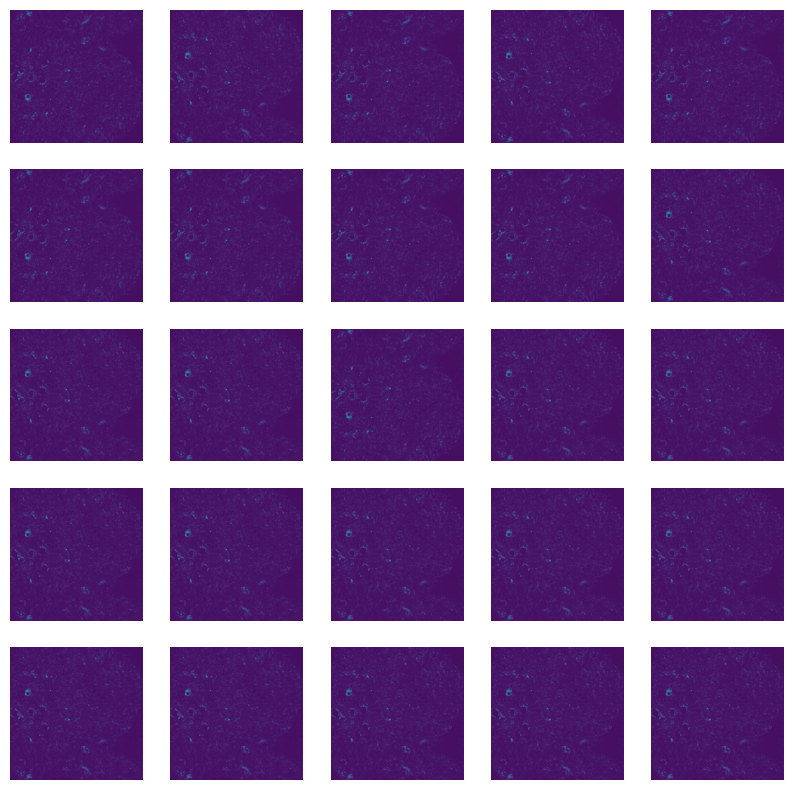

In [92]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  #layers.RandomRotation(0.2),
])
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)
image = tf.cast(tf.expand_dims(train_data1[3,:,:,1], 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(25):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [116]:
model = Sequential(data_augmentation)
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,20),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(256,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives()])
model.build((None,224,224,20))

In [117]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (1, 224, 224)             0         
                                                                 
 conv2d_119 (Conv2D)         (None, 224, 224, 32)      5792      
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 dropout_119 (Dropout)       (None, 112, 112, 32)      0         
                                                                 
 conv2d_120 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_120 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                               

Total params: 27,330,737
    
Trainable params: 27,330,737
    
Non-trainable params: 0

In [ ]:
history = model.fit(
  #train_images,
  #to_categorical(train_labels),
  #epochs=3,
  #validation_data=(test_images, to_categorical(test_labels)),
    train_data1,
    train_labels,
    epochs = 50,
    validation_data = (val_data1, val_labels)
)

Epoch 1/50
3/3 [==============================] - 15s 4s/step - loss: 0.6789 - binary_accuracy: 0.5606 - false_negatives_23: 9.0000 - false_positives_15: 20.0000 - val_loss: 0.6449 - val_binary_accuracy: 0.7059 - val_false_negatives_23: 5.0000 - val_false_positives_15: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 13s 3s/step - loss: 0.6762 - binary_accuracy: 0.7576 - false_negatives_23: 16.0000 - false_positives_15: 0.0000e+00 - val_loss: 0.6065 - val_binary_accuracy: 0.7059 - val_false_negatives_23: 5.0000 - val_false_positives_15: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 13s 3s/step - loss: 0.5742 - binary_accuracy: 0.7576 - false_negatives_23: 16.0000 - false_positives_15: 0.0000e+00 - val_loss: 0.5982 - val_binary_accuracy: 0.7059 - val_false_negatives_23: 5.0000 - val_false_positives_15: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 13s 4s/step - loss: 0.5821 - binary_accuracy: 0.7576 - false_negatives_23: 16.0000 - false_positive

/home/bgsimon/.local/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

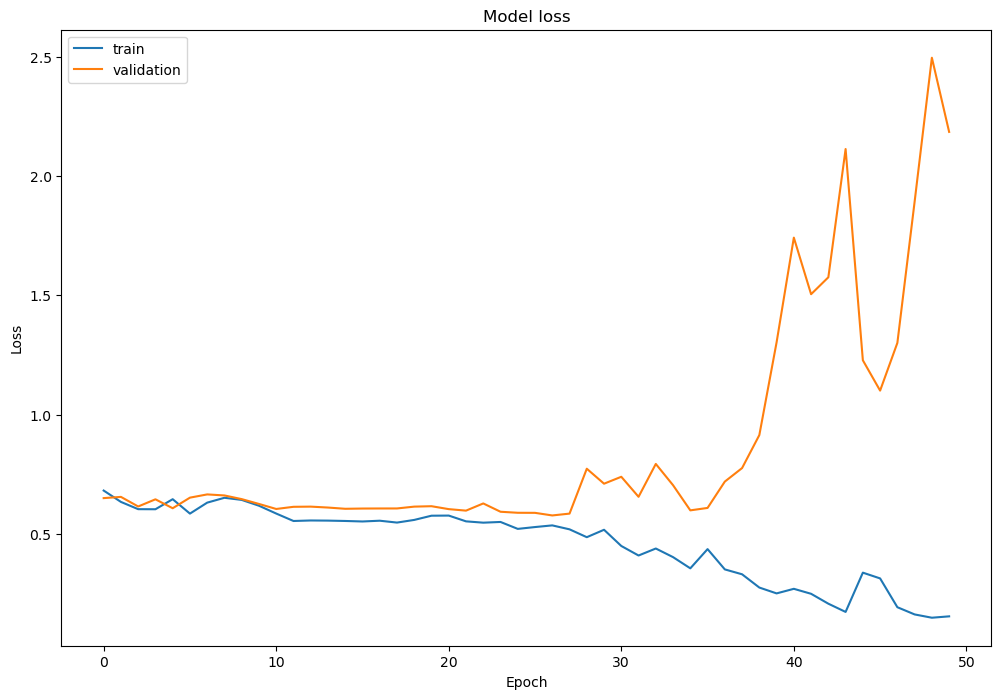

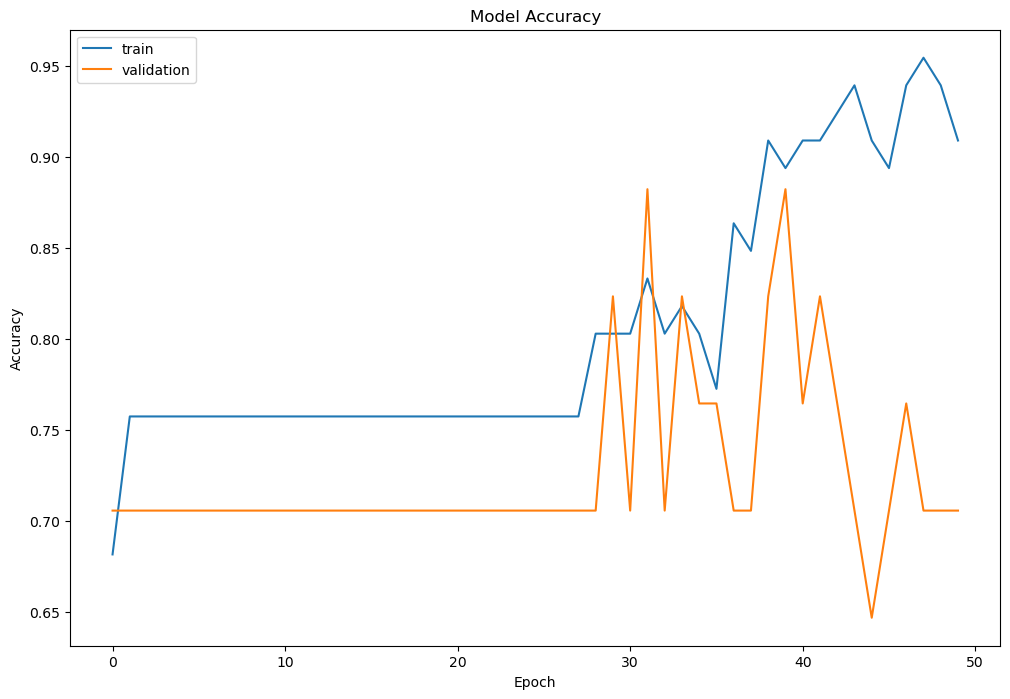

In [115]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['binary_accuracy','val_binary_accuracy']]
df_acc.rename(columns={'binary_accuracy':'train','val_binary_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')
